In [1]:
import os, json
import numpy as np
import torch.optim as optim
import torch.nn as nn
from qiskit.providers.fake_provider import FakeLima
from scripts.data_setup import load_data
from scripts.from_circ_to_numpy import operations_to_features, save_to_json, load_from_json
from scripts.model import create_models, train_and_test_step, save_models, load_models
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BackendEstimator
from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *
from qiskit_aer import AerSimulator
from sklearn.metrics import root_mean_squared_error
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

In [2]:
dir_models = 'experiments/test_2'
dir_data = 'data_small_1'

n_qubits = 5 # 5 == n_qubits, default value for now because of FakeLima
train_circuits, train_observables, train_ideal_exp_vals, train_noisy_exp_vals, test_circuits, test_observables, test_ideal_exp_vals, test_noisy_exp_vals = load_data(f'data/circuits/{dir_data}')
X_train, y_train, X_test, y_test = load_from_json(f'data/features/{dir_data}')

In [3]:
backend = FakeLima()
backend_noisy = AerSimulator.from_backend(FakeLima())

In [44]:
def get_zne_expval(circ,
                   obs: str,
                   backend,
                   shots:int=10000,
                   ) -> float:
    """Returns the zero-noise expectation values for a list of observables `obs` of a circuit `circ`
    Inputs:
    obs (list[str]): Observables in Endian convention (e.g. 'IIZ' is the Z operator on the 0th qubit) for the PHYSICAL qubits
    mapping (list[int]): Mapping between logical and physical qubits, e.g. mapping[0] is the physical qubit for logical qubit 0
    """

    observable = SparsePauliOp(obs.primitive)

    #print(obs.primitive)

    ZNEEstimator = zne(BackendEstimator)
    estimator = ZNEEstimator(backend=backend)

    # zne_strategy = ZNEStrategy(noise_factors=[1, 3, 5],
    #                            noise_amplifier=GlobalFoldingAmplifier())

    zne_strategy = ZNEStrategy(
        noise_factors=[1, 3, 5],
        noise_amplifier=GlobalFoldingAmplifier(),
        extrapolator=PolynomialExtrapolator(degree=1),
)

    job = estimator.run(circ, observable, shots=shots, zne_strategy=zne_strategy)
    values = job.result().values

    return values.tolist()

In [45]:
def zne_mitigating_single_z(circ, backend, obs):
    return get_zne_expval(circ.decompose(reps=1), obs, backend)

In [46]:
zne_mitigated = []
for i, circ in enumerate(test_circuits):
    zne_mitigated.append(zne_mitigating_single_z(circ, backend_noisy, test_observables[i]))

In [47]:
rms = root_mean_squared_error(test_ideal_exp_vals, zne_mitigated)

In [48]:
rms

0.3589186260227007

In [19]:
zne_mitigated

[[1.8352],
 [-0.03],
 [1.6274],
 [0.0906],
 [0.5690000000000001],
 [1.9916],
 [-0.1128],
 [3.7211999999999996],
 [0.12979999999999997],
 [0.1916],
 [0.0066],
 [0.055],
 [-0.4536],
 [-2.5308],
 [-0.030000000000000002],
 [-0.2512],
 [1.4294],
 [-0.016000000000000014],
 [-0.34],
 [-0.20380000000000004],
 [1.6260000000000001],
 [0.011999999999999983],
 [0.10019999999999996],
 [0.335],
 [-0.014800000000000008],
 [-0.2878],
 [0.1994],
 [-0.2482],
 [0.08360000000000001],
 [-0.1752],
 [1.5695999999999999],
 [-0.08480000000000001],
 [5.8344000000000005],
 [5.735200000000001],
 [-0.0452],
 [1.0476],
 [0.8200000000000001],
 [0.29279999999999995],
 [-1.0819999999999999],
 [1.0516],
 [0.38620000000000004],
 [0.3108000000000001],
 [-0.4585999999999999],
 [-0.9612],
 [0.2386],
 [-0.15040000000000003],
 [0.0002],
 [2.025],
 [-0.1494],
 [2.2556],
 [0.035800000000000005],
 [-0.2472],
 [0.9324],
 [0.6208],
 [1.6398],
 [0.0948],
 [1.2488],
 [0.5457999999999998],
 [0.1642],
 [-0.3812],
 [1.8726],
 [0.093],

In [13]:
test_ideal_exp_vals

[1.671875,
 -0.248046875,
 1.98828125,
 0.123046875,
 0.666015625,
 2.0078125,
 -0.189453125,
 3.76171875,
 0.125,
 0.646484375,
 -0.537109375,
 -0.048828125,
 -0.609375,
 -2.947265625,
 -0.0859375,
 -0.876953125,
 1.1875,
 -0.05078125,
 -0.658203125,
 -0.623046875,
 2.177734375,
 0.517578125,
 0.08203125,
 0.359375,
 0.400390625,
 -0.119140625,
 -0.04296875,
 0.197265625,
 0.6875,
 -0.58203125,
 1.640625,
 0.064453125,
 5.71484375,
 5.66015625,
 0.212890625,
 0.88671875,
 0.810546875,
 0.478515625,
 -1.5234375,
 0.984375,
 0.640625,
 -0.216796875,
 -0.37109375,
 -1.208984375,
 -0.5234375,
 0.8984375,
 0.04296875,
 2.03515625,
 -0.306640625,
 1.85546875,
 -0.158203125,
 -0.267578125,
 0.94921875,
 0.63671875,
 1.703125,
 -0.177734375,
 1.359375,
 0.3203125,
 0.123046875,
 -0.517578125,
 2.0,
 -0.005859375,
 0.82421875,
 -1.42578125,
 0.296875,
 1.01953125,
 -0.56640625,
 -0.0390625,
 1.4296875,
 0.21875,
 1.201171875,
 -0.869140625,
 -0.05078125,
 -0.09375,
 -0.40234375,
 -0.5703125,
 

In [14]:
test_noisy_exp_vals

[1.859375,
 0.033203125,
 1.548828125,
 0.109375,
 0.525390625,
 2.017578125,
 -0.193359375,
 3.5859375,
 0.12109375,
 0.62890625,
 -0.228515625,
 0.068359375,
 -0.427734375,
 -2.515625,
 0.01171875,
 -0.23828125,
 1.560546875,
 -0.044921875,
 -0.376953125,
 -0.134765625,
 1.970703125,
 0.12890625,
 0.0390625,
 0.39453125,
 0.09765625,
 -0.15625,
 -0.068359375,
 0.04296875,
 0.0625,
 -0.177734375,
 1.6796875,
 -0.080078125,
 5.7890625,
 5.578125,
 0.154296875,
 1.107421875,
 0.69921875,
 0.2265625,
 -1.240234375,
 1.03515625,
 0.34375,
 -0.076171875,
 -0.08203125,
 -0.8203125,
 -0.326171875,
 0.685546875,
 -0.048828125,
 2.037109375,
 -0.15625,
 2.17578125,
 0.046875,
 -0.26171875,
 0.921875,
 0.640625,
 1.619140625,
 0.0859375,
 1.30078125,
 0.48046875,
 0.16796875,
 -0.4375,
 1.89453125,
 0.13671875,
 0.994140625,
 -1.28515625,
 0.236328125,
 0.791015625,
 -0.3125,
 -0.0625,
 1.361328125,
 0.009765625,
 0.90625,
 -0.755859375,
 -0.04296875,
 0.041015625,
 -0.23828125,
 -0.33203125,
 

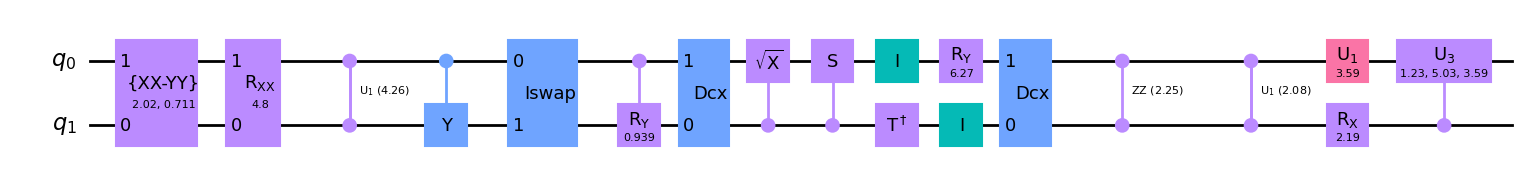

In [11]:
test_circuits[0].draw('mpl')

In [6]:
test_observables[0]

PauliSumOp(SparsePauliOp(['II', 'YX', 'II'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j]), coeff=1.0)

In [8]:
test_observables[20]

PauliSumOp(SparsePauliOp(['III', 'IYZ', 'IXX', 'XZZ', 'ZYX', 'ZIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1.0)